# Getting to cross-sections

In [2]:
import uproot
from array import array
import numpy as np
import multiprocessing, time, uuid, tempfile
import sys, math, os, subprocess, csv, hist
from ROOT import TFile, TTree, TGraph2DErrors, TH1F, gROOT, TMath
import matplotlib.pyplot as plt
import awkward as ak
import ROOT as r
from scipy.interpolate import griddata

Welcome to JupyROOT 6.28/04


\begin{equation}
    \sigma^{Born}_{data} = \frac{Y_{data}}{Y_{MC}} \cdot \sigma^{Born}_{MC}
\end{equation}

momentum 2.42
Total entries in data histogram 349209.0
prod_scale for 2.42 GeV 8.019473751969585e-05
<class cppyy.gbl.ROOT.RDF.RResultPtr<TH1D> at 0x2a73c3f40> heprime type
momentum 2.71
Total entries in data histogram 395822.0
prod_scale for 2.71 GeV 6.623779046424206e-05
<class cppyy.gbl.ROOT.RDF.RResultPtr<TH1D> at 0x2a73c3f40> heprime type
momentum 3.04
Total entries in data histogram 628961.0
prod_scale for 3.04 GeV 3.8619533507633996e-05
<class cppyy.gbl.ROOT.RDF.RResultPtr<TH1D> at 0x2a73c3f40> heprime type
momentum 3.4
Total entries in data histogram 598387.0
prod_scale for 3.4 GeV 3.6752541972072564e-05
<class cppyy.gbl.ROOT.RDF.RResultPtr<TH1D> at 0x2a73c3f40> heprime type
momentum 3.81
Total entries in data histogram 1366948.0
prod_scale for 3.81 GeV 1.3759837706580576e-05
<class cppyy.gbl.ROOT.RDF.RResultPtr<TH1D> at 0x2a73c3f40> heprime type
momentum 4.27
Total entries in data histogram 1578073.0
prod_scale for 4.27 GeV 9.259441462060242e-06
<class cppyy.gbl.ROOT.RDF.RResu

/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_37736/2235468265.py:330: RuntimeWarning: invalid value encountered in divide
  ratio_delta_2p42 = eprime_bin_contents_2p42/bin_counts_eprime_2p42
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_37736/2235468265.py:331: RuntimeWarning: invalid value encountered in divide
  ratio_delta_2p71 = eprime_bin_contents_2p71/bin_counts_eprime_2p71
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_37736/2235468265.py:332: RuntimeWarning: invalid value encountered in divide
  ratio_errors = ratio_delta_2p42 * np.sqrt((subtracted_bin_errors/subtracted_bin_contents)**2 + (bin_errors_eprime_2p42/bin_counts_eprime_2p42)**2)


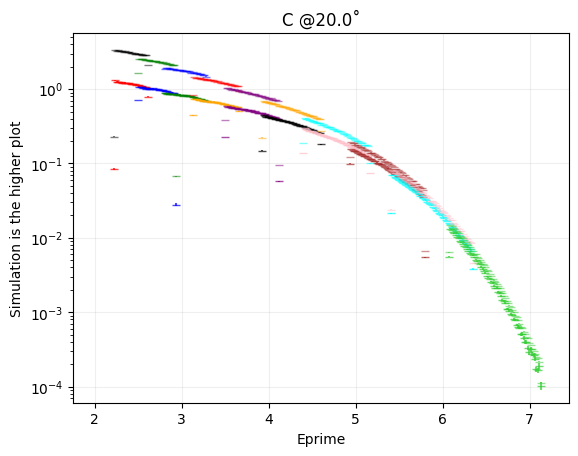

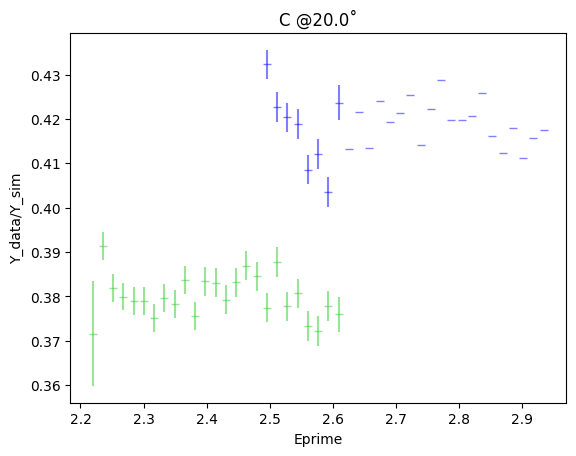

In [53]:
start_time = time.time()
r.EnableImplicitMT()

dtg = 'C12' #What is your desired target?
dang = 20.0 #What is your desired angle?
dmom = [2.42, 2.71, 3.04, 3.40, 3.81, 4.27, 4.78, 5.36, 5.878, 6.6] #What are your desired central momenta(just the magnitude)
#dmom = [2.42, 2.71]
cafe_report_path = '/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2/reportfiles/'
tinfo_path = '/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2/HMS_runlist copy.txt'
datafile_path = '/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/ROOTfiles/'
bin_num = 32*len(dmom) #half percent bins according to the resolution of the spectrometer(-8% to 8%)
bin_eprime_low = 2.0
bin_eprime_high = 7.2
run_dict = {
    6.6: [4689, 4690, 4691, 4692, 4693, 4694, 4695, 4696, 4697],
    5.878: [4755, 4757, 4758, 4759, 4760, 4761],
    5.36: [4803, 4805, 4806, 4808, 4809, 4810],
    4.78: [4846, 4847, 4848, 4849],
    4.27: [4875, 4876],
    3.81: [4901, 4902, 4903, 4904],
    3.4: [4925, 4926],
    3.04: [4947, 4949],
    2.71: [4969, 4970],
    2.42: [5004, 5005, 5006]
}

def csb(eprime):
    if dang == 20.0:
        targ = ['C12', 'Ca40', 'Ag', 'Al', 'Au', 'Be', 'B10', 'B11', 'Ca48', 'Cu', 'LD2', 'Dummy', 'Fe54', 'He3', 'He4', 'Li6', 'Li7', 'Ni58', 'Ni64', 'Sn*', 'Th', 'Ti']
        a_list = [1.766, 2.129, 1.904, 1.717, 1.789, 1.974, 1.798, 1.833, 2.218, 2.157, 2.763, 1.642, 1.723, 2.338, 2.307, 1.741, 1.845, 1.415, 1.423, None, 1.814, 1.600]
        b_list = [-2.185, -2.064, -1.951, -2.130, -1.938, -2.231, -2.206, -2.218, -2.036, -1.964, -2.423, -2.130, -2.072, -2.348, -2.278, -2.247, -2.311, -2.034, -2.037, None, -1.927, -2.103]
    if dang == 26.0:
        targ = ['C12', 'Ca40', 'LD2', 'Dummy']
        a_list = [2.244, 2.355, 3.324, 2.079]
        b_list = [-2.637, -2.338, -3.045, -2.538]
    if dang == 35.0:
        targ = ["C12", "Ca40", "Ca48", "LD2", "Dummy", "He3", "He4"]
        a_list = [2.286, 1.977, 1.917, 3.091, 2.126, 2.674, 2.627]
        b_list = [-2.935, -2.275, -2.183, -3.451, -2.778, -3.246, -3.120]
    if dtg in targ:
        i = targ.index(dtg)
        a_pow = a_list[i]
        b_pow = b_list[i]
    else:
        print("Target not found")
    csb = np.exp(a_pow + b_pow*eprime)
    return csb

# Function to read the text file into an array
def ImportRadcor(filename):
    vectors = [[] for _ in range(13)]
    with open(filename, 'r') as infile:
        for line in infile:
            if line.startswith(' *'):
                continue
            values = line.split()
            if len(values) == 13:
                for i, val in enumerate(values):
                    vectors[i].append(float(val))
    return [np.array(v) for v in vectors]

#Function to calculate scaling factors for data
def read_report(momentum):
    q = j = 0
    ls = '2'
    sf = []
    for run in run_dict[momentum]:
        cafe_report = open(cafe_report_path+"replay_hms_production_%d_-1.report"%run)
        for line in cafe_report:
            if "BCM4A Beam Cut Charge" in line:
                c2 = float((line.split(":")[1]).strip()[:-2])
            if "_factor" in line:
                f1 = float((line.split("=")[-1].strip()))
                if f1 != -1.0 :
                    #print("Prescale factor:",f1)
                    ll = f1
                    f2 = str((line.split(["="][0])))
                    ls = f2[4]
                    #print("Active trigger",f2[4])
                    continue
            if "Ps%s HMS Computer Live Time"%ls in line:
                clt = float((line.split(":")[1]).strip()[:-3])
            if "BCM4A Beam Cut Current" in line:
                cc = float((line.split(":")[1]).strip()[:-2])
            if "E SING FID" in line:
                fid = float((line.split(":")[1]).strip()[:-11])
                c2o = c2 * (1 + 0.37/cc) #Beam current offset correction
                pro = c2o * clt * 0.01
                pro2 = pro * fid #Denominator for the CNY
                sf.append(pro2/ll) #Saving the scaling factors into a list
                j=j+1
                q=q+1
    tsf = sum(sf)
    p_scale = 1/tsf
    return p_scale

def koshish5():
    #Kinematic variables
    ts = dang #Spectrometer angle
    p_spec = dmom #Just the magnitude
    Z, A = 6, 12  #Target
    density = 1.0 #Target density g/cm3
    thick = 0.574 #g/cm2. From Cameron's target sheet column 'R'

    #Constants
    Ei, Mp = 10.54, 0.93825 #Beam energy and proton mass in GeV
    N_A, Q_E = 6.02e+23, 1.60e-19 #Avogadro's number and charge in 1 electron
    al_den, length = 2.699, 10. #Density of aluminum can and length of can
    dpp_up, dpp_down = 15.0, -15.0 #Momentum acceptance upper and lower limit
    cos_ts = np.cos(np.deg2rad(ts))
    sin_ts = np.sin(np.deg2rad(ts))
    for momentum in dmom:
        ep_min = momentum * (1 + 0.01 * dpp_down)
        ep_max = momentum * (1 + 0.01 * dpp_up)
        phi_up, phi_down, theta_up, theta_down = 110.0, -110.0, 65.0, -65.0 #mrad
        domega = (phi_up - phi_down) * (theta_up - theta_down) / 1e6  #diff solid angle in sr
        sim_charge = 1.
        wall_exit, wall_ent = 0.0168, 0.02024 #in cm
        dum_thick_exit, dum_thick_ent = 0.1816, 0.1815 #g/cm2
        hyd_thick_ent = al_den * wall_ent #g/cm2
        hyd_thick_exit = al_den * wall_exit #g/cm2
        lumin = thick * sim_charge / A * N_A / Q_E * 1e-39
        ratio_ent = hyd_thick_ent / dum_thick_ent
        ratio_exit = hyd_thick_exit / dum_thick_exit
        #prod_scale = ps_factor / charge*clt*eff
        string = str(momentum).replace('-', '').replace('.', 'p').rstrip('0')

    ################################################################################### DATA WORK #########################################################################################
    
    #Define the data cuts
    data_cut = "-8 < H_gtr_dp && H_gtr_dp < 8 && H_cal_etottracknorm > 0.7 && abs(H_gtr_ph) < 0.032 && abs(H_gtr_th) < 0.085 && H_cer_npeSum > 2 && H_bcm_CurrentFlag == 1"

    def root_hist_to_numpy(root_hist):
        bin_edges = np.array([root_hist.GetXaxis().GetBinLowEdge(i) for i in range(1, root_hist.GetNbinsX() + 2)])
        bin_contents = np.array([root_hist.GetBinContent(i) for i in range(1, root_hist.GetNbinsX() + 1)])
        bin_errors = np.array([root_hist.GetBinError(i) for i in range(1, root_hist.GetNbinsX() + 1)])
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        return bin_centers, bin_contents, bin_errors

    heprime_sum = None
    histograms = {}
    for momentum in dmom:
        print("momentum", momentum)
        #Create a TChain
        ch = r.TChain("T")

        for run in run_dict[momentum]:
            ch.Add(f'/Users/AbSir/Desktop/MC_Yield/ROOTfiles/HMS_{run}_skim.root')
        df = r.RDataFrame(ch)  #Create an RDataFrame from the TChain
        prod_scale = read_report(momentum)
        #Apply the cuts to the chained dataframe
        hc = df.Filter(data_cut)\
            .Define("Eprime", f"{momentum}*(1 + 0.01*H_gtr_dp)")
        
        #Create the histograms from the dataframe
        heprime = hc.Histo1D(("Eprime", "Eprime", bin_num, bin_eprime_low, bin_eprime_high), "Eprime")
        heprime.Sumw2()
        hdeltadat = hc.Histo1D(("Delta", "Delta", bin_num, -8.0, 8.0), "H_gtr_dp")
        hdeltadat.Sumw2()
        print("Total entries in data histogram", heprime.GetEntries())
        heprime.Scale(prod_scale)
        print(f"prod_scale for {momentum} GeV", prod_scale)
        print(type(heprime),"heprime type")
        heprime_th = heprime.GetValue()
        histograms[momentum] = heprime_th.Clone()
    
    #fig refers to the entire canvas on which plots are drawn. ax refers to a single plot/subplot
    fig, ax = plt.subplots()
    eprime_bin_centers_2p42, eprime_bin_contents_2p42, eprime_bin_errors_2p42 = root_hist_to_numpy(histograms[2.42])
    eprime_bin_centers_2p71, eprime_bin_contents_2p71, eprime_bin_errors_2p71 = root_hist_to_numpy(histograms[2.71])
    eprime_bin_centers_3p04, eprime_bin_contents_3p04, eprime_bin_errors_3p04 = root_hist_to_numpy(histograms[3.04])
    eprime_bin_centers_3p4, eprime_bin_contents_3p4, eprime_bin_errors_3p4 = root_hist_to_numpy(histograms[3.4])
    eprime_bin_centers_3p81, eprime_bin_contents_3p81, eprime_bin_errors_3p81 = root_hist_to_numpy(histograms[3.81])
    eprime_bin_centers_4p27, eprime_bin_contents_4p27, eprime_bin_errors_4p27 = root_hist_to_numpy(histograms[4.27])
    eprime_bin_centers_4p78, eprime_bin_contents_4p78, eprime_bin_errors_4p78 = root_hist_to_numpy(histograms[4.78])
    eprime_bin_centers_5p36, eprime_bin_contents_5p36, eprime_bin_errors_5p36 = root_hist_to_numpy(histograms[5.36])
    eprime_bin_centers_5p878, eprime_bin_contents_5p878, eprime_bin_errors_5p878 = root_hist_to_numpy(histograms[5.878])
    eprime_bin_centers_6p6, eprime_bin_contents_6p6, eprime_bin_errors_6p6 = root_hist_to_numpy(histograms[6.6])

    ax.errorbar(eprime_bin_centers_2p42, eprime_bin_contents_2p42, yerr = eprime_bin_errors_2p42, fmt = '_', color = 'red', alpha = 0.7, label = '2.42 GeV')
    ax.errorbar(eprime_bin_centers_2p71, eprime_bin_contents_2p71, yerr = eprime_bin_errors_2p71, fmt = '_', color = 'blue', alpha = 0.7, label = '2.71 GeV')
    ax.errorbar(eprime_bin_centers_3p04, eprime_bin_contents_3p04, yerr = eprime_bin_errors_3p04, fmt = '_', color = 'green', alpha = 0.7, label = '3.04 GeV')
    ax.errorbar(eprime_bin_centers_3p4, eprime_bin_contents_3p4, yerr = eprime_bin_errors_3p4, fmt = '_', color = 'orange', alpha = 0.7, label = '3.4 GeV')
    ax.errorbar(eprime_bin_centers_3p81, eprime_bin_contents_3p81, yerr = eprime_bin_errors_3p81, fmt = '_', color = 'purple', alpha = 0.7, label = '3.81 GeV')
    ax.errorbar(eprime_bin_centers_4p27, eprime_bin_contents_4p27, yerr = eprime_bin_errors_4p27, fmt = '_', color = 'black', alpha = 0.7, label = '4.27 GeV')
    ax.errorbar(eprime_bin_centers_4p78, eprime_bin_contents_4p78, yerr = eprime_bin_errors_4p78, fmt = '_', color = 'pink', alpha = 0.7, label = '4.78 GeV')
    ax.errorbar(eprime_bin_centers_5p36, eprime_bin_contents_5p36, yerr = eprime_bin_errors_5p36, fmt = '_', color = 'brown', alpha = 0.7, label = '5.36 GeV')
    ax.errorbar(eprime_bin_centers_5p878, eprime_bin_contents_5p878, yerr = eprime_bin_errors_5p878, fmt = '_', color = 'cyan', alpha = 0.7, label = '5.878 GeV')
    ax.errorbar(eprime_bin_centers_6p6, eprime_bin_contents_6p6, yerr = eprime_bin_errors_6p6, fmt = '_', color = 'limegreen', alpha = 0.7, label = '6.6 GeV')

    #Perform charge symmetric background subtraction
    #eprime_contents = p_spec*(1 + 0.01*delta_bin_contents)
    csb_contents_2p42 = csb(eprime_bin_contents_2p42)

    #print("Length of csb", len(csb_contents))
    print("Average charge symmetric background electrons", np.mean(csb_contents_2p42))
    prod_scale_2p42 = read_report(2.42)
    subtracted_bin_contents = eprime_bin_contents_2p42 - (csb_contents_2p42*prod_scale_2p42)
    #subtracted_bin_contents = delta_bin_contents
    subtracted_bin_errors = np.sqrt(eprime_bin_errors_2p42**2 + (csb_contents_2p42*prod_scale)**2)

    # Check if IMT is enabled
    if r.IsImplicitMTEnabled():
        nthreads = r.ROOT.GetThreadPoolSize()
        print(f"Implicit multithreading is enabled, using {nthreads} cores.")
    else:
        print("Implicit MT is not enabled.")

    ###########################################################################################      SIMULATION WORK     ########################################################################

    #Read the Cross-section table
    V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13 = ImportRadcor("/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2/xsec_tables/xem2_20degcarbon22_hms.out")
    size = len(V1)

    #Fixing the binning for the simulation histograms
    hseprime_min = bin_eprime_low
    hseprime_max = bin_eprime_high
    hseprime_num_bins = bin_num
    hseprime_binwidth = (hseprime_max - hseprime_min) / hseprime_num_bins
    hseprime_binedges = np.arange(hseprime_min, hseprime_max + hseprime_binwidth, hseprime_binwidth)
    print("hseprime_binwidth:", hseprime_binwidth)

    Eprime_dict = {}
    xsec_array = {}
    mc_scale = {}
    for momentum in dmom:
        string = str(momentum).replace('-', '').replace('.', 'p').rstrip('0')
        filepath = f"/Users/AbSir/Desktop/MC_Yield/ROOTfiles/hms_mc_c_20degm{string}.root"

        # Open the file and tree
        file = uproot.open(filepath)
        tree = file["h1"]

        # Load the branches
        electrons = tree.arrays(["hsdelta", "hsytar", "hsyptar", "hsxptar", "stop_id"], library='np')    
        nentries = len(electrons["hsdelta"])

        # Apply the cuts
        mc_cut = (np.abs(electrons["hsdelta"]) < 8) & \
                (np.abs(electrons["hsyptar"]) < 0.032) & \
                (np.abs(electrons["hsxptar"]) < 0.085) & \
                (electrons["stop_id"] == 0)

        # Filter 'hsdelta' with the cuts
        hsdelta_cut = electrons["hsdelta"][mc_cut]
        hsyptar_cut = electrons["hsyptar"][mc_cut]
        hsxptar_cut = electrons["hsxptar"][mc_cut]

        # Calculate E' and theta(in degrees)
        Eprime_dict[momentum] = momentum*(1 + 0.01*hsdelta_cut)
        thetarad = np.arccos((cos_ts + hsyptar_cut*sin_ts)/np.sqrt(1 + hsxptar_cut*hsxptar_cut + hsyptar_cut*hsyptar_cut))
        thetadeg = np.rad2deg(thetarad)
        
        # Perform the interpolation
        points = np.array([V2, V3]).T #Make a 2D array and transpose it so each array is of the form [E',theta]
        points_to_interpolate = np.column_stack((Eprime_dict[momentum], thetadeg))
        xsec_array[momentum] = griddata(points, V9, points_to_interpolate, method='linear') #Specify the 2D array of [E's, thetas] as first argument; Radiative cross-section(V9) as the z-axis and (Ep, theta) as the point for which we need the cross-section
        mc_scale[momentum] = lumin * domega * (ep_max - ep_min) / nentries         # Calculate the scale for simulation
        print("Average of xsec_array", np.mean(xsec_array[momentum]))

    #This function returns 2 arrays: bin counts(the counts in each bin taking weights into account) and bin edges(the edges of the bins)
    bin_counts_eprime_2p42, bin_edges_eprime_2p42 = np.histogram(Eprime_dict[2.42], weights = xsec_array[2.42] * mc_scale[2.42], bins = hseprime_binedges)
    bin_counts_eprime_2p71, bin_edges_eprime_2p71 = np.histogram(Eprime_dict[2.71], weights = xsec_array[2.71] * mc_scale[2.71], bins = hseprime_binedges)
    bin_counts_eprime_3p04, bin_edges_eprime_3p04 = np.histogram(Eprime_dict[3.04], weights = xsec_array[3.04] * mc_scale[3.04], bins = hseprime_binedges)
    bin_counts_eprime_3p4, bin_edges_eprime_3p4 = np.histogram(Eprime_dict[3.4], weights = xsec_array[3.4] * mc_scale[3.4], bins = hseprime_binedges)
    bin_counts_eprime_3p81, bin_edges_eprime_3p81 = np.histogram(Eprime_dict[3.81], weights = xsec_array[3.81] * mc_scale[3.81], bins = hseprime_binedges)
    bin_counts_eprime_4p27, bin_edges_eprime_4p27 = np.histogram(Eprime_dict[4.27], weights = xsec_array[4.27] * mc_scale[4.27], bins = hseprime_binedges)
    bin_counts_eprime_4p78, bin_edges_eprime_4p78 = np.histogram(Eprime_dict[4.78], weights = xsec_array[4.78] * mc_scale[4.78], bins = hseprime_binedges)
    bin_counts_eprime_5p36, bin_edges_eprime_5p36 = np.histogram(Eprime_dict[5.36], weights = xsec_array[5.36] * mc_scale[5.36], bins = hseprime_binedges)
    bin_counts_eprime_5p878, bin_edges_eprime_5p878 = np.histogram(Eprime_dict[5.878], weights = xsec_array[5.878] * mc_scale[5.878], bins = hseprime_binedges)
    bin_counts_eprime_6p6, bin_edges_eprime_6p6 = np.histogram(Eprime_dict[6.6], weights = xsec_array[6.6] * mc_scale[6.6], bins = hseprime_binedges)
    #bin_sqares contains the square of the error for each bin
    bin_squares_eprime_2p42, _ = np.histogram(Eprime_dict[2.42], weights = (xsec_array[2.42] * mc_scale[2.42])**2, bins = hseprime_binedges)
    bin_squares_eprime_2p71, _ = np.histogram(Eprime_dict[2.71], weights = (xsec_array[2.71] * mc_scale[2.71])**2, bins = hseprime_binedges)
    bin_squares_eprime_3p04, _ = np.histogram(Eprime_dict[3.04], weights = (xsec_array[3.04] * mc_scale[3.04])**2, bins = hseprime_binedges)
    bin_squares_eprime_3p4, _ = np.histogram(Eprime_dict[3.4], weights = (xsec_array[3.4] * mc_scale[3.4])**2, bins = hseprime_binedges)
    bin_squares_eprime_3p81, _ = np.histogram(Eprime_dict[3.81], weights = (xsec_array[3.81] * mc_scale[3.81])**2, bins = hseprime_binedges)
    bin_squares_eprime_4p27, _ = np.histogram(Eprime_dict[4.27], weights = (xsec_array[4.27] * mc_scale[4.27])**2, bins = hseprime_binedges)
    bin_squares_eprime_4p78, _ = np.histogram(Eprime_dict[4.78], weights = (xsec_array[4.78] * mc_scale[4.78])**2, bins = hseprime_binedges)
    bin_squares_eprime_5p36, _ = np.histogram(Eprime_dict[5.36], weights = (xsec_array[5.36] * mc_scale[5.36])**2, bins = hseprime_binedges)
    bin_squares_eprime_5p878, _ = np.histogram(Eprime_dict[5.878], weights = (xsec_array[5.878] * mc_scale[5.878])**2, bins = hseprime_binedges)
    bin_squares_eprime_6p6, _ = np.histogram(Eprime_dict[6.6], weights = (xsec_array[6.6] * mc_scale[6.6])**2, bins = hseprime_binedges)
    #Calculating the actual error for each bin
    bin_errors_eprime_2p42 = np.sqrt(bin_squares_eprime_2p42)
    bin_errors_eprime_2p71 = np.sqrt(bin_squares_eprime_2p71)
    bin_errors_eprime_3p04 = np.sqrt(bin_squares_eprime_3p04)
    bin_errors_eprime_3p4 = np.sqrt(bin_squares_eprime_3p4)
    bin_errors_eprime_3p81 = np.sqrt(bin_squares_eprime_3p81)
    bin_errors_eprime_4p27 = np.sqrt(bin_squares_eprime_4p27)
    bin_errors_eprime_4p78 = np.sqrt(bin_squares_eprime_4p78)
    bin_errors_eprime_5p36 = np.sqrt(bin_squares_eprime_5p36)
    bin_errors_eprime_5p878 = np.sqrt(bin_squares_eprime_5p878)
    bin_errors_eprime_6p6 = np.sqrt(bin_squares_eprime_6p6)
    #The bin centers are calculated for plotting purposes. bin_edges[:-1] is all bin edges except the last, and bin_edges[1:] is all bin edges except the first.
    bin_centers_eprime_2p42 = (bin_edges_eprime_2p42[:-1] + bin_edges_eprime_2p42[1:]) / 2
    bin_centers_eprime_2p71 = (bin_edges_eprime_2p71[:-1] + bin_edges_eprime_2p71[1:]) / 2
    bin_centers_eprime_3p04 = (bin_edges_eprime_3p04[:-1] + bin_edges_eprime_3p04[1:]) / 2
    bin_centers_eprime_3p4 = (bin_edges_eprime_3p4[:-1] + bin_edges_eprime_3p4[1:]) / 2
    bin_centers_eprime_3p81 = (bin_edges_eprime_3p81[:-1] + bin_edges_eprime_3p81[1:]) / 2
    bin_centers_eprime_4p27 = (bin_edges_eprime_4p27[:-1] + bin_edges_eprime_4p27[1:]) / 2
    bin_centers_eprime_4p78 = (bin_edges_eprime_4p78[:-1] + bin_edges_eprime_4p78[1:]) / 2
    bin_centers_eprime_5p36 = (bin_edges_eprime_5p36[:-1] + bin_edges_eprime_5p36[1:]) / 2
    bin_centers_eprime_5p878 = (bin_edges_eprime_5p878[:-1] + bin_edges_eprime_5p878[1:]) / 2
    bin_centers_eprime_6p6 = (bin_edges_eprime_6p6[:-1] + bin_edges_eprime_6p6[1:]) / 2

    #Plotting the histogram with error bars
    ax.errorbar(bin_centers_eprime_2p42, bin_counts_eprime_2p42, yerr = bin_errors_eprime_2p42, fmt = '_', color = 'black', alpha = 0.5, label = 'Sim 2.42 GeV')
    ax.errorbar(bin_centers_eprime_2p71, bin_counts_eprime_2p71, yerr = bin_errors_eprime_2p71, fmt = '_', color = 'green', alpha = 0.5, label = 'Sim 2.71 GeV')
    ax.errorbar(bin_centers_eprime_3p04, bin_counts_eprime_3p04, yerr = bin_errors_eprime_3p04, fmt = '_', color = 'blue', alpha = 0.5, label = 'Sim 3.04 GeV')
    ax.errorbar(bin_centers_eprime_3p4, bin_counts_eprime_3p4, yerr = bin_errors_eprime_3p4, fmt = '_', color = 'red', alpha = 0.5, label = 'Sim 3.4 GeV')
    ax.errorbar(bin_centers_eprime_3p81, bin_counts_eprime_3p81, yerr = bin_errors_eprime_3p81, fmt = '_', color = 'purple', alpha = 0.5, label = 'Sim 3.81 GeV')
    ax.errorbar(bin_centers_eprime_4p27, bin_counts_eprime_4p27, yerr = bin_errors_eprime_4p27, fmt = '_', color = 'orange', alpha = 0.5, label = 'Sim 4.27 GeV')
    ax.errorbar(bin_centers_eprime_4p78, bin_counts_eprime_4p78, yerr = bin_errors_eprime_4p78, fmt = '_', color = 'cyan', alpha = 0.5, label = 'Sim 4.78 GeV')
    ax.errorbar(bin_centers_eprime_5p36, bin_counts_eprime_5p36, yerr = bin_errors_eprime_5p36, fmt = '_', color = 'brown', alpha = 0.5, label = 'Sim 5.36 GeV')
    ax.errorbar(bin_centers_eprime_5p878, bin_counts_eprime_5p878, yerr = bin_errors_eprime_5p878, fmt = '_', color = 'pink', alpha = 0.5, label = 'Sim 5.878 GeV')
    ax.errorbar(bin_centers_eprime_6p6, bin_counts_eprime_6p6, yerr = bin_errors_eprime_6p6, fmt = '_', color = 'limegreen', alpha = 0.5, label = 'Sim 6.6 GeV')
    ax.grid(True, alpha = 0.2)
    ax.set_xlabel('Eprime')
    ax.set_ylabel('Simulation is the higher plot')
    ax.set_yscale('log')
    # ax.legend() 
    ax.set_title(f'C @{dang}˚')
    fig.savefig(f'eprime_{dtg}_{dang}_{start_time:.0f}.pdf')

    print("Total entries in simulation histogram", len(hsdelta_cut))
    print("mc_scale", mc_scale)

    #print("Bins in simulation histogram", len(bin_counts))
    
    ratio_delta_2p42 = eprime_bin_contents_2p42/bin_counts_eprime_2p42
    ratio_delta_2p71 = eprime_bin_contents_2p71/bin_counts_eprime_2p71
    ratio_errors = ratio_delta_2p42 * np.sqrt((subtracted_bin_errors/subtracted_bin_contents)**2 + (bin_errors_eprime_2p42/bin_counts_eprime_2p42)**2)

    fig2, ax2 = plt.subplots()
    # Ensure all error values are non-negative
    ratio_errors_non_negative = np.abs(ratio_errors)
    ax2.errorbar(bin_centers_eprime_2p42, ratio_delta_2p42, yerr = ratio_errors_non_negative, fmt = '_', alpha = 0.5, color = 'limegreen', label = '2.42 GeV')
    ax2.errorbar(bin_centers_eprime_2p71, ratio_delta_2p71, yerr = ratio_errors_non_negative, fmt = '_', alpha = 0.5, color = 'blue', label = '2.71 GeV')
    ax2.set_xlabel('Eprime')
    ax2.set_ylabel('Y_data/Y_sim')
    ax2.set_title(f'C @{dang}˚')

    # delta_array = np.zeros(bin_num)
    # for b in range(bin_num):
    #     delta_array[b] = -7.75 + 0.5*b
    # #print("delta_array", delta_array)
    # eprime_array = p_spec*(1 + 0.01*delta_array)

    # points_to_interpolate2 = np.column_stack((eprime_array, np.full(len(eprime_array), 20)))
    # born_xsec_array = griddata(points, V6, points_to_interpolate2, method='linear')
    # # print("Length of born_xsec_array", len(born_xsec_array))

    # fig5, ax5 = plt.subplots()
    # born_cross = ratio_delta * born_xsec_array
    # # print("Length of born_cross", len(born_cross))
    # # print("Born cross section", born_cross)
    # born_errors = born_cross * ratio_errors
    # ax5.errorbar(bin_centers_eprime_2p42, born_cross, yerr = born_errors, fmt = '_', color = 'limegreen', alpha = 0.7, label = 'Weighted cross-section')
    # ax5.set_xlabel('Delta')
    # ax5.set_ylabel('Born Cross Section')
    # ax5.set_title(f'C -{dmom}GeV@{dang}˚')
    # #ax5.legend()
    # ax5.grid(True, alpha = 0.2)
    # fig5.savefig(f'xsec_{string}_{dang}_{start_time:.0f}.png')


if __name__ == "__main__":
    koshish5()